In [7]:
import torch
from utils import *
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Model checkpoints
srgan_checkpoint = "./checkpoint_srgan.pth.tar"
srresnet_checkpoint = "./checkpoint_srresnet.pth.tar"

In [3]:
# Load models
srresnet = torch.load(srresnet_checkpoint, map_location="cpu")['model'].to(device)
srresnet.eval()
srgan_generator = torch.load(srgan_checkpoint, map_location="cpu")['generator'].to(device)
srgan_generator.eval()


c:\Users\trong\Downloads\New folder\SuperResolution\models.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  out_channels = (n_channels if i is 0 else in_channels * 2) if i % 2 is 0 else in_channels
c:\Users\trong\Downloads\New folder\SuperResolution\models.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  out_channels = (n_channels if i is 0 else in_channels * 2) if i % 2 is 0 else in_channels
c:\Users\trong\Downloads\New folder\SuperResolution\models.py:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  stride=1 if i % 2 is 0 else 2, batch_norm=i is not 0, activation='LeakyReLu'))
c:\Users\trong\Downloads\New folder\SuperResolution\models.py:258: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  stride=1 if i % 2 is 0 else 2, batch_norm=i is not 0, activation='LeakyReLu'))
c:\Users\trong\Downloads\honda_spotweld\venv\lib\site-packages\torch\serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.S

Generator(
  (net): SRResNet(
    (conv_block1): ConvolutionalBlock(
      (conv_block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (1): PReLU(num_parameters=1)
      )
    )
    (residual_blocks): Sequential(
      (0): ResidualBlock(
        (conv_block1): ConvolutionalBlock(
          (conv_block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): PReLU(num_parameters=1)
          )
        )
        (conv_block2): ConvolutionalBlock(
          (conv_block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
      )
      (1): ResidualBlock(
        (conv_block1): ConvolutionalBlock(
          (conv_block): Seque

In [8]:
def visualize_sr(img, halve=False):
    """
    Visualizes the super-resolved images from the SRResNet and SRGAN for comparison with the bicubic-upsampled image
    and the original high-resolution (HR) image, as done in the paper.

    :param img: filepath of the HR iamge
    :param halve: halve each dimension of the HR image to make sure it's not greater than the dimensions of your screen?
                  For instance, for a 2160p HR image, the LR image will be of 540p (1080p/4) resolution. On a 1080p screen,
                  you will therefore be looking at a comparison between a 540p LR image and a 1080p SR/HR image because
                  your 1080p screen can only display the 2160p SR/HR image at a downsampled 1080p. This is only an
                  APPARENT rescaling of 2x.
                  If you want to reduce HR resolution by a different extent, modify accordingly.
    """
    # Load image, downsample to obtain low-res version
    hr_img = Image.open(img, mode="r")
    hr_img = hr_img.convert('RGB')
    if halve:
        hr_img = hr_img.resize((int(hr_img.width / 2), int(hr_img.height / 2)),
                               Image.LANCZOS)
    lr_img = hr_img.resize((int(hr_img.width / 4), int(hr_img.height / 4)),
                           Image.BICUBIC)

    # Bicubic Upsampling
    bicubic_img = lr_img.resize((hr_img.width, hr_img.height), Image.BICUBIC)

    # Super-resolution (SR) with SRResNet
    sr_img_srresnet = srresnet(convert_image(lr_img, source='pil', target='imagenet-norm').unsqueeze(0).to(device))
    sr_img_srresnet = sr_img_srresnet.squeeze(0).cpu().detach()
    sr_img_srresnet = convert_image(sr_img_srresnet, source='[-1, 1]', target='pil')

    # Super-resolution (SR) with SRGAN
    sr_img_srgan = srgan_generator(convert_image(lr_img, source='pil', target='imagenet-norm').unsqueeze(0).to(device))
    sr_img_srgan = sr_img_srgan.squeeze(0).cpu().detach()
    sr_img_srgan = convert_image(sr_img_srgan, source='[-1, 1]', target='pil')

    # Create grid
    margin = 40
    grid_img = Image.new('RGB', (2 * hr_img.width + 3 * margin, 2 * hr_img.height + 3 * margin), (255, 255, 255))

    # Font
    draw = ImageDraw.Draw(grid_img)
    try:
        font = ImageFont.truetype("calibril.ttf", size=23)
        # It will also look for this file in your OS's default fonts directory, where you may have the Calibri Light font installed if you have MS Office
        # Otherwise, use any TTF font of your choice
    except OSError:
        print(
            "Defaulting to a terrible font. To use a font of your choice, include the link to its TTF file in the function.")
        font = ImageFont.load_default()

    # Place bicubic-upsampled image
    grid_img.paste(bicubic_img, (margin, margin))
    text_size = font.getsize("Bicubic")
    draw.text(xy=[margin + bicubic_img.width / 2 - text_size[0] / 2, margin - text_size[1] - 5], text="Bicubic",
              font=font,
              fill='black')

    # Place SRResNet image
    grid_img.paste(sr_img_srresnet, (2 * margin + bicubic_img.width, margin))
    text_size = font.getsize("SRResNet")
    draw.text(
        xy=[2 * margin + bicubic_img.width + sr_img_srresnet.width / 2 - text_size[0] / 2, margin - text_size[1] - 5],
        text="SRResNet", font=font, fill='black')

    # Place SRGAN image
    grid_img.paste(sr_img_srgan, (margin, 2 * margin + sr_img_srresnet.height))
    text_size = font.getsize("SRGAN")
    draw.text(
        xy=[margin + bicubic_img.width / 2 - text_size[0] / 2, 2 * margin + sr_img_srresnet.height - text_size[1] - 5],
        text="SRGAN", font=font, fill='black')

    # Place original HR image
    grid_img.paste(hr_img, (2 * margin + bicubic_img.width, 2 * margin + sr_img_srresnet.height))
    text_size = font.getsize("Original HR")
    draw.text(xy=[2 * margin + bicubic_img.width + sr_img_srresnet.width / 2 - text_size[0] / 2,
                  2 * margin + sr_img_srresnet.height - text_size[1] - 1], text="Original HR", font=font, fill='black')

    # Display grid
    grid_img.show()
    plt.imshow(grid_img)

    return grid_img


C:\Users\trong\AppData\Local\Temp/ipykernel_30068/566344443.py:21: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
C:\Users\trong\AppData\Local\Temp/ipykernel_30068/566344443.py:24: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  bicubic_img = lr_img.resize((hr_img.width, hr_img.height), Image.BICUBIC)
C:\Users\trong\AppData\Local\Temp/ipykernel_30068/566344443.py:53: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_size = font.getsize("Bicubic")
C:\Users\trong\AppData\Local\Temp/ipykernel_30068/566344443.py:60: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_size = font.getsize("SRResNet")
C:\Users\trong\AppData\Local\Temp/ipykernel_30068/566344443.py:67: Depreca

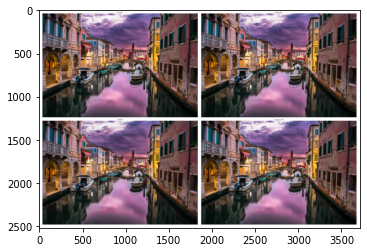

In [9]:
grid_img = visualize_sr(".\\federico-beccari-ryC3SVUeRgY-unsplash.jpg")

C:\Users\trong\AppData\Local\Temp/ipykernel_30068/566344443.py:21: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
C:\Users\trong\AppData\Local\Temp/ipykernel_30068/566344443.py:24: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  bicubic_img = lr_img.resize((hr_img.width, hr_img.height), Image.BICUBIC)
C:\Users\trong\AppData\Local\Temp/ipykernel_30068/566344443.py:53: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_size = font.getsize("Bicubic")
C:\Users\trong\AppData\Local\Temp/ipykernel_30068/566344443.py:60: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_size = font.getsize("SRResNet")
C:\Users\trong\AppData\Local\Temp/ipykernel_30068/566344443.py:67: Depreca

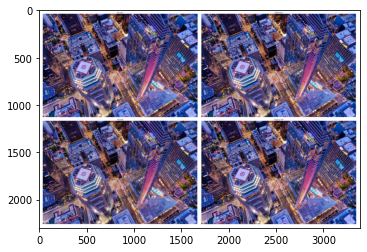

In [10]:
grid_img = visualize_sr(".\\venti-views-_yBEzQQoC3Y-unsplash.jpg")